# Comparing the neighborhoods of Darmstadt and Karlsruhe - Data Science Study

This notebook contains the source code and visualizations of the data science study mentioned above. The study represents the 
final project of the online course 'Applied Data Science Capstone' on [coursera.org](https://www.coursera.org/learn/applied-data-science-capstone).
The main goal is to find out which neighborhoods of the two cities Karlsruhe and Darmstdt are similar to each other. Further information
can be found in the full report that can be found in the same repository. 

## 1. Getting information on the neighborhoods in the two cities

In [3]:
# import libraries
import numpy as np
import requests # getting HTML content
import pandas as pd
from bs4 import BeautifulSoup # this is needed to scrape the tables from Wikipedia
import re # regular expressions
from geopy.geocoders import Nominatim # get local coordinates for areas

Scraping the data on the boroughs, neighborhoods and population density from the respective Wikipedia websites:

In [4]:
# Darmstadt
url_da='https://de.wikipedia.org/wiki/Liste_der_Stadtteile_von_Darmstadt'
# Create a handle, page, to handle the contents of the website
page_da = requests.get(url_da).text
soup_da = BeautifulSoup(page_da,'lxml')
#print(soup_da.prettify)

In [7]:
# Karlsruhe
url_ka='https://de.wikipedia.org/wiki/Liste_der_Stadtteile_von_Karlsruhe'
# Create a handle, page, to handle the contents of the website
page_ka = requests.get(url_ka).text
soup_ka = BeautifulSoup(page_ka,'lxml')
#print(soup_ka.prettify)

Find the table contents in the Wikipedia pages:

In [8]:
# Darmstadt
table_da = soup_da.find('table',{'class':'wikitable sortable'})
#table_da

In [9]:
# Karlsruhe
table_ka = soup_ka.find('table',{'class':'wikitable sortable'})
#table_ka

Extract the full content of the tables and save it as list:

In [12]:
# Darmstadt
table_rows = table_da.find_all('tr')
content_da = []
for i in table_rows:
    td = i.find_all('td')
    row = [i.text.strip() for i in td if i.text.strip()]
    if row:
        content_da.append(row)

#content_da

In [13]:
# Karlsruhe
for span_tag in table_ka.findAll('span'):
    span_tag.replace_with('')

table_rows = table_ka.find_all('tr')
content_ka = []
for i in table_rows:
    td = i.find_all('td')
    row = [i.text.strip() for i in td if i.text.strip()]
    if row:
        content_ka.append(row)

#content_ka

Get the names of the columns of both tables:

In [14]:
# Darmstadt
table_headers= table_da.find_all('th')
headers_da = []
for i in table_headers:
    name=i.text.replace("\n","")
    headers_da.append(name)
# Remove last column, as it is a picture column
headers_da=headers_da[:-1]
headers_da

['Nr.[3]',
 'Statistischer Bezirk/Stadtteil[3]',
 'Fläche in ha(Stand:\xa031.\xa0Dez.\xa02010)[3]',
 'Einwohner(Stand:\xa031.\xa0Dez.\xa02010)[3]',
 'Einwohner je ha(Stand:\xa031.\xa0Dez.\xa02010)[3]']

In [15]:
# Karlsruhe
table_headers= table_ka.find_all('th')
headers_ka = []
for i in table_headers:
    name=i.text.replace("\n","")
    headers_ka.append(name)
headers_ka

['Nr.',
 'StadtteilStadtviertel',
 'Fläche (ha)31. Dez. 2008',
 'Bevölkerung31. Dez. 2008',
 'Bevölkerungs-dichte']

Let’s make a pandas data frame out of it. Let's proceed by conducting all preparation steps for Darmstadt first. Then we will continue with the steps for Karlsruhe.

### 1.1 Making a data frame for Darmstadt

In [16]:
df_da_t1 = pd.DataFrame(content_da,columns=headers_da)
df_da_t1.head()

,Nr.[3],Statistischer Bezirk/Stadtteil[3],Fläche in ha(Stand: 31. Dez. 2010)[3],Einwohner(Stand: 31. Dez. 2010)[3],Einwohner je ha(Stand: 31. Dez. 2010)[3]
0,100,Darmstadt-Mitte,"233,0",17611,"75,6"
1,110,Stadtzentrum,"30,0",1419,"47,3"
2,120,Rheintor/Grafenstraße,"39,9",3565,"89,4"
3,130,Hochschulviertel,"41,5",571,"13,8"
4,140,Kapellplatzviertel,"49,7",5341,"107,5"


Clean the columns that are of no interest and translate the column headers:

In [17]:
df_da_t1.columns=['Identifier','Neighborhood','Area in ha','Inhabitants','Density Inh/ha']

Clean the summarizing rows that contain text in 'Identifier'. Furthermore, let's extract the respective boroughs' names, indicated by idenitfier with the number '*00' to an extra column:

In [18]:
df_da_t1.drop([28,46,47],inplace=True)

In [19]:
df_da_t1['Borough']='tbd'

Let's define a useful function that enables a clean depiction of the boroughs and their neighborhoods considering the specific format of the tables for both original Darmstadt and Karlsruhe data:

In [20]:
def groupToBoroughs(df,identifier):
    if(identifier=='DA'):
        for index, row in df.iterrows():
            if(re.search('.00',row.Identifier)):
                borough_name=row['Neighborhood']
                #print(borough_name)
            row['Borough']=borough_name
    elif(identifier=='KA'):
        for index, row in df.iterrows():
            if(re.search('^\d{2}$',row.Identifier)):
                borough_name=row['Neighborhood']
                #print(borough_name)
            row['Borough']=borough_name
    else:
        print("Unknown identifier: ",identifier)
        exit()
        
    #df.head()
    #Now clean the general rows which are identifiable now since borough and neighborhood names are identical
    df_clean=df.drop(df[df.Borough==df.Neighborhood].index)
    return df_clean    

Applying that function for Darmstadt:

In [21]:
df_da_t2=groupToBoroughs(df_da_t1,'DA')

In [23]:
df_da_t2.head()

,Identifier,Neighborhood,Area in ha,Inhabitants,Density Inh/ha,Borough
1,110,Stadtzentrum,"30,0",1419,"47,3",Darmstadt-Mitte
2,120,Rheintor/Grafenstraße,"39,9",3565,"89,4",Darmstadt-Mitte
3,130,Hochschulviertel,"41,5",571,"13,8",Darmstadt-Mitte
4,140,Kapellplatzviertel,"49,7",5341,"107,5",Darmstadt-Mitte
5,150,St. Ludwig mit Eichbergviertel,"72,0",6715,"93,3",Darmstadt-Mitte


Reorder the columns:

In [24]:
# Reorder columns
df_da_t3 = df_da_t2[['Identifier', 'Borough', 'Neighborhood', 'Inhabitants','Area in ha', 'Density Inh/ha']]

In [25]:
df_da_t3.head()

,Identifier,Borough,Neighborhood,Inhabitants,Area in ha,Density Inh/ha
1,110,Darmstadt-Mitte,Stadtzentrum,1419,"30,0","47,3"
2,120,Darmstadt-Mitte,Rheintor/Grafenstraße,3565,"39,9","89,4"
3,130,Darmstadt-Mitte,Hochschulviertel,571,"41,5","13,8"
4,140,Darmstadt-Mitte,Kapellplatzviertel,5341,"49,7","107,5"
5,150,Darmstadt-Mitte,St. Ludwig mit Eichbergviertel,6715,"72,0","93,3"


Adapt the german number sparator rules to the universal ones:

In [29]:
df_da_t3['Inhabitants']=pd.to_numeric(df_da_t3['Inhabitants'])
df_da_t3["Area in ha"] = df_da_t3["Area in ha"].str.replace(",",".")
df_da_t3["Area in ha"] = df_da_t3["Area in ha"].str.replace(" ","")
df_da_t3['Area in ha']=pd.to_numeric(df_da_t3['Area in ha'])
df_da_t3["Density Inh/ha"] = df_da_t3["Density Inh/ha"].str.replace(",",".")
df_da_t3.head()

AttributeError: Can only use .str accessor with string values, which use np.object_ dtype in pandas

Now that we have the names and population densities of Darmstadt's boroughs and neighborhoods, let's get their geographical. coordinates. For this task, we write again a function that does this job for us (and is useable for the Karlsruhe data later as well).

In [32]:
# this is needed to insert a pause which is in turn needed to avoid an annoying timeout error in geolocator
from time import sleep

In [42]:
def addCoordinatesToDF(df):
    geolocator = Nominatim()
    df_new=df.copy(deep=True)
    df_new['Latitude']='tbd'
    df_new['Longitude']='tbd'
    
    for i in df_new.index:
        borough_ = df_new.get_value(i,'Borough')
        neigh_   = df_new.get_value(i,'Neighborhood')
        
        try:
            location = geolocator.geocode("%s %s"%(borough_,neigh_))
            print("%s %s: %f,%f"%(borough_,neigh_,location.latitude,location.longitude))
            df_new.set_value( i,'Latitude',location.latitude)
            df_new.set_value( i,'Longitude',location.longitude)
        except:
            #location = geolocator.geocode("%s"%(borough_))
            print("Attention - couldn't find combination %s/%s, need to manage it manually!" %(borough_,neigh_))
        sleep(1.5)
    return df_new

In [43]:
df_da=addCoordinatesToDF(df_da_t3)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Darmstadt-Mitte Stadtzentrum: 49.872754,8.651161


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Darmstadt-Mitte Rheintor/Grafenstraße: 49.871606,8.647955
Darmstadt-Mitte Hochschulviertel: 49.876262,8.656890
Darmstadt-Mitte Kapellplatzviertel: 49.870864,8.659611
Darmstadt-Mitte St. Ludwig mit Eichbergviertel: 49.865945,8.652891
Darmstadt-Nord Johannesviertel: 49.878497,8.646980
Darmstadt-Nord Martinsviertel-West: 49.881000,8.658658
Darmstadt-Nord Martinsviertel-Ost: 49.879970,8.663805
Darmstadt-Nord Waldkolonie: 49.880212,8.618938
Darmstadt-Nord Mornewegviertel: 49.873056,8.637765
Darmstadt-Nord Pallaswiesenviertel: 49.880700,8.640945
Darmstadt-Nord Am Ziegelbusch: 49.885033,8.663485
Darmstadt-Ost Am Oberfeld: 49.879560,8.674064
Darmstadt-Ost Mathildenhöhe: 49.876814,8.667162
Darmstadt-Ost Woogsviertel: 49.869939,8.668695
Darmstadt-Ost An den Lichtwiesen: 49.865614,8.674185
Darmstadt-Bessungen Paulusviertel: 49.862124,8.660440
Darmstadt-Bessungen Alt-Bessungen: 49.859369,8.651541
Darmstadt-Bessungen An der Ludwigshöhe: 49.843035,8.663026
Darmstadt-West Am Südbahnhof: 49.856078,8.6

Let's manage to get the coordinates of the non-found neighborhoods manually.

In [58]:
# Alt-Arheilgen, data from https://tools.wmflabs.org/geohack/geohack.php?params=49.91262_N_8.65797_E_dim:10000_region:DE-HE_type:city(4169)&pagename=Alt-Arheilgen&language=de
df_da.at[30,'Latitude']=49.91262
df_da.at[30,'Longitude']=8.65797

In [59]:
df_da

,Identifier,Borough,Neighborhood,Inhabitants,Area in ha,Density Inh/ha,Latitude,Longitude
1,110,Darmstadt-Mitte,Stadtzentrum,1419,30.0,47.3,49.8728,8.65116
2,120,Darmstadt-Mitte,Rheintor/Grafenstraße,3565,39.9,89.4,49.8716,8.64796
3,130,Darmstadt-Mitte,Hochschulviertel,571,41.5,13.8,49.8763,8.65689
4,140,Darmstadt-Mitte,Kapellplatzviertel,5341,49.7,107.5,49.8709,8.65961
5,150,Darmstadt-Mitte,St. Ludwig mit Eichbergviertel,6715,72.0,93.3,49.8659,8.65289
7,210,Darmstadt-Nord,Johannesviertel,4839,38.3,126.4,49.8785,8.64698
8,220,Darmstadt-Nord,Martinsviertel-West,5576,37.9,147.0,49.881,8.65866
9,230,Darmstadt-Nord,Martinsviertel-Ost,5365,29.1,184.6,49.88,8.66381
10,240,Darmstadt-Nord,Waldkolonie,4291,448.5,9.6,49.8802,8.61894
11,250,Darmstadt-Nord,Mornewegviertel,650,52.4,12.4,49.8731,8.63776


### 1.2 Making a data frame for Darmstadt

Now create a shiny pandas data frame for the data of Karlsruhe.

In [60]:
df_ka_t1 = pd.DataFrame(content_ka,columns=headers_ka)
df_ka_t1.head()

,Nr.,StadtteilStadtviertel,Fläche (ha)31. Dez. 2008,Bevölkerung31. Dez. 2008,Bevölkerungs-dichte
0,01,Innenstadt-Ost,"160,12",5.890,3.679
1,011,Nordöstl. Teil,"128,83",1.252,972
2,012,Südwestl. Teil,"31,28",4.638,14.827
3,02,Innenstadt-West,"240,32",8.769,3.649
4,021,Östlicher Teil,"80,33",1.814,2.258


Transform and reorganize the column to get the same format like in the Darmstadt table:

In [61]:
df_ka_t1.columns=['Identifier','Neighborhood','Area in ha','Inhabitants','Density Inh/ha']
df_ka_t1['Borough']='tbd'
df_ka_t2=df_ka_t1.drop([92,93,94])
df_ka_t2.head()

,Identifier,Neighborhood,Area in ha,Inhabitants,Density Inh/ha,Borough
0,01,Innenstadt-Ost,"160,12",5.890,3.679,tbd
1,011,Nordöstl. Teil,"128,83",1.252,972,tbd
2,012,Südwestl. Teil,"31,28",4.638,14.827,tbd
3,02,Innenstadt-West,"240,32",8.769,3.649,tbd
4,021,Östlicher Teil,"80,33",1.814,2.258,tbd


In [62]:
df_ka_t3=groupToBoroughs(df_ka_t2,'KA')
df_ka_t3.head()

,Identifier,Neighborhood,Area in ha,Inhabitants,Density Inh/ha,Borough
1,011,Nordöstl. Teil,"128,83",1.252,972,Innenstadt-Ost
2,012,Südwestl. Teil,"31,28",4.638,14.827,Innenstadt-Ost
4,021,Östlicher Teil,"80,33",1.814,2.258,Innenstadt-West
5,022,Westlicher Teil,"159,99",6.955,4.347,Innenstadt-West
7,031,Nördlicher Teil,"38,08",6.214,16.318,Südstadt


In [63]:
# Reorder columns
df_ka_t4 = df_ka_t3[['Identifier', 'Borough', 'Neighborhood', 'Inhabitants','Area in ha','Density Inh/ha']]

In [64]:
df_ka_t4.head()

,Identifier,Borough,Neighborhood,Inhabitants,Area in ha,Density Inh/ha
1,011,Innenstadt-Ost,Nordöstl. Teil,1.252,"128,83",972
2,012,Innenstadt-Ost,Südwestl. Teil,4.638,"31,28",14.827
4,021,Innenstadt-West,Östlicher Teil,1.814,"80,33",2.258
5,022,Innenstadt-West,Westlicher Teil,6.955,"159,99",4.347
7,031,Südstadt,Nördlicher Teil,6.214,"38,08",16.318


In [65]:
df_ka_t4["Inhabitants"] = df_ka_t4["Inhabitants"].str.replace(".","")
df_ka_t4["Area in ha"] = df_ka_t4["Area in ha"].str.replace(".","")
df_ka_t4["Area in ha"] = df_ka_t4["Area in ha"].str.replace(",",".")
df_ka_t4["Density Inh/ha"] = df_ka_t4["Density Inh/ha"].str.replace(".","")
df_ka_t4.head()

,Identifier,Borough,Neighborhood,Inhabitants,Area in ha,Density Inh/ha
1,011,Innenstadt-Ost,Nordöstl. Teil,1252,128.83,972
2,012,Innenstadt-Ost,Südwestl. Teil,4638,31.28,14827
4,021,Innenstadt-West,Östlicher Teil,1814,80.33,2258
5,022,Innenstadt-West,Westlicher Teil,6955,159.99,4347
7,031,Südstadt,Nördlicher Teil,6214,38.08,16318


In [66]:
df_ka_t4['Density Inh/ha']=pd.to_numeric(df_ka_t4['Density Inh/ha'])
# Now correct unit to get Inh/ha
df_ka_t4['Density Inh/ha']=df_ka_t4['Density Inh/ha']/100

In [67]:
df_ka_t4.head()

,Identifier,Borough,Neighborhood,Inhabitants,Area in ha,Density Inh/ha
1,011,Innenstadt-Ost,Nordöstl. Teil,1252,128.83,9.72
2,012,Innenstadt-Ost,Südwestl. Teil,4638,31.28,148.27
4,021,Innenstadt-West,Östlicher Teil,1814,80.33,22.58
5,022,Innenstadt-West,Westlicher Teil,6955,159.99,43.47
7,031,Südstadt,Nördlicher Teil,6214,38.08,163.18


Let's get the coordinates for the Karslruhe neighborhoods:

In [68]:
df_ka=addCoordinatesToDF(df_ka_t4)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Attention - couldn't find combination Innenstadt-Ost/Nordöstl. Teil, need to manage it manually!
Attention - couldn't find combination Innenstadt-Ost/Südwestl. Teil, need to manage it manually!
Innenstadt-West Östlicher Teil: 49.011818,8.402726


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Innenstadt-West Westlicher Teil: 49.014847,8.393182
Südstadt Nördlicher Teil: 49.003372,8.408212
Südstadt Südlicher Teil: 48.995544,8.413061
Südstadt Östlicher Teil: 49.002057,8.419140
Südweststadt Östlicher Teil: 48.998120,8.398865
Südweststadt Mittlerer Teil: 49.000002,8.390050
Südweststadt Beiertheimer Feld: 48.999181,8.378254
Weststadt Mittlerer Teil: 49.013467,8.378470
Weststadt Südlicher Teil: 49.005543,8.372510
Nordweststadt Alter Flugplatz: 49.028738,8.375457
Nordweststadt Binsenschlauch: 49.024591,8.368255
Nordweststadt Lange Richtstatt: 49.037066,8.367481
Nordweststadt Rennbuckel: 49.027149,8.359936
Oststadt Nördlicher Teil: 49.017898,8.431106
Oststadt Südlicher Teil: 49.004730,8.432043
Oststadt Westlicher Teil: 49.018880,8.419088
Mühlburg Alt-Mühlburg: 49.014282,8.362075
Mühlburg Weingärtensiedlung: 49.020287,8.357200
Mühlburg Rheinhafen: 49.018837,8.339402
Mühlburg Mühlburger Feld: 49.007261,8.364817
Daxlanden Alt-Daxlanden: 48.999195,8.310111
Daxlanden Neu-Daxlanden: 49.00

In [77]:
# Innenstadt-Ost/Nordöstl. Teil, determined using https://www.gpskoordinaten.de
df_ka.at[1,'Latitude']=49.018376
df_ka.at[1,'Longitude']=8.410939800000051

# Innenstadt-Ost/Südwestl. Teil, determined using https://www.gpskoordinaten.de
df_ka.at[2,'Latitude']=49.0094097 
df_ka.at[2,'Longitude']=8.40942259999997

# Grünwinkel/Alte Heidenstücker, determined using https://www.gpskoordinaten.de
df_ka.at[2,'Latitude']=48.98959
df_ka.at[2,'Longitude']=8.351609999999937

In [78]:
df_ka.head()

,Identifier,Borough,Neighborhood,Inhabitants,Area in ha,Density Inh/ha,Latitude,Longitude
1,011,Innenstadt-Ost,Nordöstl. Teil,1252,128.83,9.72,49.0184,8.41094
2,012,Innenstadt-Ost,Südwestl. Teil,4638,31.28,148.27,48.9896,8.35161
4,021,Innenstadt-West,Östlicher Teil,1814,80.33,22.58,49.0118,8.40273
5,022,Innenstadt-West,Westlicher Teil,6955,159.99,43.47,49.0148,8.39318
7,031,Südstadt,Nördlicher Teil,6214,38.08,163.18,49.0034,8.40821


## 2. Analyzing the data of Darmstadt and Karlsruhe

Load further libraries:

In [214]:
#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

Use geopy library to get the latitude and longitude values of Darmstadt and Karlsruhe. For this 

In [215]:
def plotFoliumMap(cityname,df,zoom=10):
    geolocator = Nominatim()
    location = geolocator.geocode(cityname)
    latitude = location.latitude
    longitude = location.longitude
    
    # create map of the city using latitude and longitude values
    map_city = folium.Map(location=[latitude, longitude], zoom_start=zoom)
    
    # add markers to map
    for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
        label = '{}, {}'.format(neighborhood, borough)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_city)  
    
    return map_city

In [216]:
map_ka = plotFoliumMap('Karlsruhe', df_ka,11)
map_ka

In [217]:
map_da = plotFoliumMap('Darmstadt', df_da,11)
map_da

Now let's get the information about the venues of each neighborhood of the two cities from foursquare:

In [218]:
# The code was removed by Watson Studio for sharing.

In [263]:
lat=49.865614
lng=8.393048
radius=500
LIMIT=500

url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
results = requests.get(url).json()

In [264]:
results["response"]["venues"]

[{'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/stadium_soccer_',
     'suffix': '.png'},
    'id': '4cce455aebf7b749d5e191f5',
    'name': 'Soccer Field',
    'pluralName': 'Soccer Fields',
    'primary': True,
    'shortName': 'Soccer Field'}],
  'hasPerk': False,
  'id': '4eb68cac823131626fb73d22',
  'location': {'address': 'Neugasse 27',
   'cc': 'DE',
   'city': 'Geinsheim',
   'country': 'Deutschland',
   'distance': 1120,
   'formattedAddress': ['Neugasse 27', '65468 Geinsheim', 'Deutschland'],
   'labeledLatLngs': [{'label': 'display', 'lat': 49.87555, 'lng': 8.395571}],
   'lat': 49.87555,
   'lng': 8.395571,
   'postalCode': '65468',
   'state': 'Hessen'},
  'name': 'SV 07 Geinsheim',
  'referralId': 'v-1548245673'},
 {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_',
     'suffix': '.png'},
    'id': '4bf58dd8d48988d110941735',
    'name': 'Italian Restaurant',
    'pluralName': 'Italian

In [300]:
#results["response"]["venues"][0]['name']
resT=results["response"]["venues"]
venT = []
for v in resT:
    if(len(v["categories"])>0):
        venT.append((v["name"],
              v["location"]["lat"],
              v["location"]["lng"],
              v["categories"][0]["name"]))
#print(venT)
#venT2=[]
#venT2.append([(v["name"],
#              v["location"]["lat"],
#              v["location"]["lng"])for v in resT])
#print(venT2)
np.shape(venT)
#nearby_venues = pd.DataFrame(venT)
nearby_venues = pd.DataFrame.from_records(venT)
nearby_venues
#print(nearby_venues)
#nearby_venues.columns = ['Venue', 
#                  'Venue Latitude', 
#                  'Venue Longitude', 
#                  'Venue Category']
    


,0,1,2,3
0,SV 07 Geinsheim,49.875550,8.395571,Soccer Field
1,Pompei,49.880934,8.394982,Italian Restaurant
2,Vogelsee,49.876185,8.379856,Lake
3,Geinsheim,49.885303,8.399632,Village
4,Naturheilpraxis Krumbein,49.880216,8.394069,Doctor's Office
5,Auto Werkstatt Fritsch Trebur Geinsheim,49.879448,8.398252,Auto Garage
6,Post,49.853124,8.353031,Post Office
7,Baggersee,49.875454,8.383834,Lake
8,DLRG Oppenheim,49.858591,8.358219,Fire Station
9,Fahrschule Schöneberg,49.857245,8.360284,School


Add the information about the respective city and merge the two dataframes of the cities: 

In [220]:
df_ka.insert(0, 'City', 'KA')
df_da.insert(0, 'City', 'DA')
df_da

,City,Identifier,Borough,Neighborhood,Inhabitants,Area in ha,Density Inh/ha,Latitude,Longitude
1,DA,110,Darmstadt-Mitte,Stadtzentrum,1419,30.0,47.3,49.8728,8.65116
2,DA,120,Darmstadt-Mitte,Rheintor/Grafenstraße,3565,39.9,89.4,49.8716,8.64796
3,DA,130,Darmstadt-Mitte,Hochschulviertel,571,41.5,13.8,49.8763,8.65689
4,DA,140,Darmstadt-Mitte,Kapellplatzviertel,5341,49.7,107.5,49.8709,8.65961
5,DA,150,Darmstadt-Mitte,St. Ludwig mit Eichbergviertel,6715,72.0,93.3,49.8659,8.65289
7,DA,210,Darmstadt-Nord,Johannesviertel,4839,38.3,126.4,49.8785,8.64698
8,DA,220,Darmstadt-Nord,Martinsviertel-West,5576,37.9,147.0,49.881,8.65866
9,DA,230,Darmstadt-Nord,Martinsviertel-Ost,5365,29.1,184.6,49.88,8.66381
10,DA,240,Darmstadt-Nord,Waldkolonie,4291,448.5,9.6,49.8802,8.61894
11,DA,250,Darmstadt-Nord,Mornewegviertel,650,52.4,12.4,49.8731,8.63776


In [315]:
def getNearbyVenues(city, borough, neigh, inhabitants, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for city, bor, name, inh, lat, lng in zip(city,borough, neigh, inhabitants, latitudes, longitudes):
        print(city,bor,name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        #results = requests.get(url).json()["response"]['groups'][0]['items']
        res_temp = requests.get(url).json()["response"]["venues"]
        #res_temp=results["response"]["venues"]
        
        # return only relevant information for each nearby venue
        for v in res_temp:
            if(len(v["categories"])>0):
                venues_list.append((
                    city,
                    bor,
                    name, 
                    inh,
                    lat, 
                    lng, 
                    v["name"],
                    v["location"]["lat"],
                    v["location"]["lng"], 
                    v["categories"][0]["name"]))

    nearby_venues = pd.DataFrame.from_records(venues_list)
    nearby_venues.columns = ['City',
                  'Borough',
                  'Neighborhood', 
                  'Density Inh/ha',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [312]:
# merging
df_both = pd.concat([df_da,df_ka])
df_both

,City,Identifier,Borough,Neighborhood,Inhabitants,Area in ha,Density Inh/ha,Latitude,Longitude
1,DA,110,Darmstadt-Mitte,Stadtzentrum,1419,30,47.3,49.8728,8.65116
2,DA,120,Darmstadt-Mitte,Rheintor/Grafenstraße,3565,39.9,89.4,49.8716,8.64796
3,DA,130,Darmstadt-Mitte,Hochschulviertel,571,41.5,13.8,49.8763,8.65689
4,DA,140,Darmstadt-Mitte,Kapellplatzviertel,5341,49.7,107.5,49.8709,8.65961
5,DA,150,Darmstadt-Mitte,St. Ludwig mit Eichbergviertel,6715,72,93.3,49.8659,8.65289
7,DA,210,Darmstadt-Nord,Johannesviertel,4839,38.3,126.4,49.8785,8.64698
8,DA,220,Darmstadt-Nord,Martinsviertel-West,5576,37.9,147.0,49.881,8.65866
9,DA,230,Darmstadt-Nord,Martinsviertel-Ost,5365,29.1,184.6,49.88,8.66381
10,DA,240,Darmstadt-Nord,Waldkolonie,4291,448.5,9.6,49.8802,8.61894
11,DA,250,Darmstadt-Nord,Mornewegviertel,650,52.4,12.4,49.8731,8.63776


Now get the venues of all neighbourhoods in the two cities:

In [316]:
LIMIT = 500 # limit of number of venues returned by Foursquare API
radius = 500 # define radius in m

In [317]:
venues = getNearbyVenues(city=df_both['City'],
                            borough=df_both['Borough'],
                            neigh=df_both['Neighborhood'],
                            inhabitants=df_both['Density Inh/ha'],
                            latitudes=df_both['Latitude'],
                            longitudes=df_both['Longitude']
                           )

DA Darmstadt-Mitte Stadtzentrum
DA Darmstadt-Mitte Rheintor/Grafenstraße
DA Darmstadt-Mitte Hochschulviertel
DA Darmstadt-Mitte Kapellplatzviertel
DA Darmstadt-Mitte St. Ludwig mit Eichbergviertel
DA Darmstadt-Nord Johannesviertel
DA Darmstadt-Nord Martinsviertel-West
DA Darmstadt-Nord Martinsviertel-Ost
DA Darmstadt-Nord Waldkolonie
DA Darmstadt-Nord Mornewegviertel
DA Darmstadt-Nord Pallaswiesenviertel
DA Darmstadt-Nord Am Ziegelbusch
DA Darmstadt-Ost Am Oberfeld
DA Darmstadt-Ost Mathildenhöhe
DA Darmstadt-Ost Woogsviertel
DA Darmstadt-Ost An den Lichtwiesen
DA Darmstadt-Bessungen Paulusviertel
DA Darmstadt-Bessungen Alt-Bessungen
DA Darmstadt-Bessungen An der Ludwigshöhe
DA Darmstadt-West Am Südbahnhof
DA Darmstadt-West Heimstättensiedlung
DA Darmstadt-West Verlegerviertel
DA Darmstadt-West Am Kavalleriesand
DA Darmstadt-Arheilgen Alt-Arheilgen
DA Darmstadt-Arheilgen Arheilgen-Süd
DA Darmstadt-Arheilgen Arheilgen-West
DA Darmstadt-Arheilgen Arheilgen-Ost
DA Darmstadt-Eberstadt Alt-E

In [319]:
venues

,City,Borough,Neighborhood,Density Inh/ha,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,DA,Darmstadt-Mitte,Stadtzentrum,47.3,49.872754,8.651161,Luisenplatz,49.872802,8.651197,Plaza
1,DA,Darmstadt-Mitte,Stadtzentrum,47.3,49.872754,8.651161,Starbucks,49.872698,8.650989,Coffee Shop
2,DA,Darmstadt-Mitte,Stadtzentrum,47.3,49.872754,8.651161,H Luisenplatz,49.872812,8.650930,Tram Station
3,DA,Darmstadt-Mitte,Stadtzentrum,47.3,49.872754,8.651161,Darmstadt Shop,49.872631,8.651575,Tourist Information Center
4,DA,Darmstadt-Mitte,Stadtzentrum,47.3,49.872754,8.651161,Back-Factory,49.872350,8.651028,Bakery
5,DA,Darmstadt-Mitte,Stadtzentrum,47.3,49.872754,8.651161,Postbank Finanzcenter,49.873066,8.650269,Bank
6,DA,Darmstadt-Mitte,Stadtzentrum,47.3,49.872754,8.651161,Praxis Drs. med. Murmann,49.872965,8.651920,Doctor's Office
7,DA,Darmstadt-Mitte,Stadtzentrum,47.3,49.872754,8.651161,Ludwigsturm,49.872819,8.651185,Monument / Landmark
8,DA,Darmstadt-Mitte,Stadtzentrum,47.3,49.872754,8.651161,Neues Rathaus am Luisenplatz,49.872775,8.650888,City Hall
9,DA,Darmstadt-Mitte,Stadtzentrum,47.3,49.872754,8.651161,Telekom Shop,49.872905,8.650967,Mobile Phone Shop


In [320]:
venues.groupby(['City','Borough','Neighborhood'])['Venue'].count()

City  Borough                 Neighborhood                  
DA    Darmstadt-Arheilgen     Alt-Arheilgen                     113
                              Arheilgen-Ost                     115
                              Arheilgen-Süd                      68
                              Arheilgen-West                    113
      Darmstadt-Bessungen     Alt-Bessungen                     126
                              An der Ludwigshöhe                148
                              Paulusviertel                     117
      Darmstadt-Eberstadt     Alt-Eberstadt                     104
                              Am Frankenstein                   128
                              Am Lämmchesberg                   112
                              Kirchtannensiedlung               125
                              Villenkolonie                     152
      Darmstadt-Kranichstein  Kranichstein-Nord                 122
                              Kranichstein-Süd         

In [321]:
print('There are {} unique categories in the two cities.'.format(len(venues['Venue Category'].unique())))

There are 511 unique categories in the two cities.


## Analysis

In [322]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
density_scaled = scaler.fit_transform(venues[['Density Inh/ha']])
density_scaled

array([[ 0.25339859],
       [ 0.25339859],
       [ 0.25339859],
       ..., 
       [ 0.16617727],
       [ 0.16617727],
       [ 0.16617727]])

In [326]:
venues

,City,Borough,Neighborhood,Density Inh/ha,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,DA,Darmstadt-Mitte,Stadtzentrum,47.3,49.872754,8.651161,Luisenplatz,49.872802,8.651197,Plaza
1,DA,Darmstadt-Mitte,Stadtzentrum,47.3,49.872754,8.651161,Starbucks,49.872698,8.650989,Coffee Shop
2,DA,Darmstadt-Mitte,Stadtzentrum,47.3,49.872754,8.651161,H Luisenplatz,49.872812,8.650930,Tram Station
3,DA,Darmstadt-Mitte,Stadtzentrum,47.3,49.872754,8.651161,Darmstadt Shop,49.872631,8.651575,Tourist Information Center
4,DA,Darmstadt-Mitte,Stadtzentrum,47.3,49.872754,8.651161,Back-Factory,49.872350,8.651028,Bakery
5,DA,Darmstadt-Mitte,Stadtzentrum,47.3,49.872754,8.651161,Postbank Finanzcenter,49.873066,8.650269,Bank
6,DA,Darmstadt-Mitte,Stadtzentrum,47.3,49.872754,8.651161,Praxis Drs. med. Murmann,49.872965,8.651920,Doctor's Office
7,DA,Darmstadt-Mitte,Stadtzentrum,47.3,49.872754,8.651161,Ludwigsturm,49.872819,8.651185,Monument / Landmark
8,DA,Darmstadt-Mitte,Stadtzentrum,47.3,49.872754,8.651161,Neues Rathaus am Luisenplatz,49.872775,8.650888,City Hall
9,DA,Darmstadt-Mitte,Stadtzentrum,47.3,49.872754,8.651161,Telekom Shop,49.872905,8.650967,Mobile Phone Shop


In [329]:
# one hot encoding
venues_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add region info columns back to dataframe
venues_onehot.insert(0, 'CityName', venues['City'])
venues_onehot.insert(1, 'BoroughName', venues['Borough'])
venues_onehot.insert(2, 'NeighborhoodName', venues['Neighborhood'])
venues_onehot.insert(3, 'Scaled Pop. Density', density_scaled)

venues_onehot

,CityName,BoroughName,NeighborhoodName,Scaled Pop. Density,ATM,Accessories Store,Adult Boutique,Adult Education Center,Advertising Agency,Afghan Restaurant,...,Well,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,DA,Darmstadt-Mitte,Stadtzentrum,0.253399,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,DA,Darmstadt-Mitte,Stadtzentrum,0.253399,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,DA,Darmstadt-Mitte,Stadtzentrum,0.253399,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,DA,Darmstadt-Mitte,Stadtzentrum,0.253399,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,DA,Darmstadt-Mitte,Stadtzentrum,0.253399,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,DA,Darmstadt-Mitte,Stadtzentrum,0.253399,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,DA,Darmstadt-Mitte,Stadtzentrum,0.253399,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,DA,Darmstadt-Mitte,Stadtzentrum,0.253399,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,DA,Darmstadt-Mitte,Stadtzentrum,0.253399,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,DA,Darmstadt-Mitte,Stadtzentrum,0.253399,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by city/borough/neighborhood/Scaled Pop. density by taking the mean of the frequency of occurrence of each category

In [330]:
venues_grouped = venues_onehot.groupby(['CityName','BoroughName','NeighborhoodName','Scaled Pop. Density']).mean().reset_index()

In [331]:
type(venues_grouped['NeighborhoodName'])

pandas.core.series.Series

Let's print each neighborhood along with the top 5 most common venues

In [332]:
num_top_venues = 10

for (index,hood) in venues_grouped['NeighborhoodName'].iteritems():
    print("---- "+venues_grouped.at[index,'CityName']+" / "+venues_grouped.at[index,'BoroughName']+" / "+hood+" ----")
    temp=venues_grouped[venues_grouped['NeighborhoodName'] == hood].T.reset_index()
    #print(temp)
    temp.columns = ['Venue','Freq']
    temp = temp.iloc[4:]
    temp['Freq'] = temp['Freq'].astype(float)
    temp = temp.round({'Freq': 2})
    print(temp.sort_values('Freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- DA / Darmstadt-Arheilgen / Alt-Arheilgen ----
                Venue  Freq
0              Office  0.08
1            Building  0.04
2               Hotel  0.04
3        Tram Station  0.04
4  Italian Restaurant  0.03
5                Bank  0.03
6    Dentist's Office  0.03
7      Ice Cream Shop  0.03
8      Hardware Store  0.02
9         Supermarket  0.02


---- DA / Darmstadt-Arheilgen / Arheilgen-Ost ----
                Venue  Freq
0              Office  0.07
1        Tram Station  0.05
2            Building  0.03
3      Ice Cream Shop  0.03
4                Bank  0.03
5  Italian Restaurant  0.03
6               Hotel  0.03
7    Dentist's Office  0.03
8     Conference Room  0.02
9         Supermarket  0.02


---- DA / Darmstadt-Arheilgen / Arheilgen-Süd ----
                Venue  Freq
0               Hotel  0.06
1          Courthouse  0.04
2  Salon / Barbershop  0.04
3            Building  0.03
4            Bus Stop  0.03
5    Asian Restaurant  0.03
6                 Bar  0.03
7  

ValueError: Length mismatch: Expected axis has 4 elements, new values have 2 elements

## Let's cluster the neighborhoods

In [333]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

In [334]:
venues_cluster=venues_grouped.copy()

venues_cluster.drop(columns=['CityName','BoroughName','NeighborhoodName'], inplace=True)
venues_cluster

,Scaled Pop. Density,ATM,Accessories Store,Adult Boutique,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,Alternative Healer,American Restaurant,...,Well,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0.107123,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.008850,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.030451,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.008696,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.237085,0.000000,0.000000,0.000000,0.014706,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.065253,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.008850,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.470364,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.007937,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.019032,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.013514,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.207722,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.008547,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.108755,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.038608,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.058728,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Check the optimal value for k in kmeans clustering via elbow method

In [335]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    print('Modeling kMeans with k=%i'%(k))
    km = KMeans(n_clusters=k, random_state=0).fit(venues_cluster)
    Sum_of_squared_distances.append(km.inertia_)

Modeling kMeans with k=1
Modeling kMeans with k=2
Modeling kMeans with k=3
Modeling kMeans with k=4
Modeling kMeans with k=5
Modeling kMeans with k=6
Modeling kMeans with k=7
Modeling kMeans with k=8
Modeling kMeans with k=9
Modeling kMeans with k=10
Modeling kMeans with k=11
Modeling kMeans with k=12
Modeling kMeans with k=13
Modeling kMeans with k=14


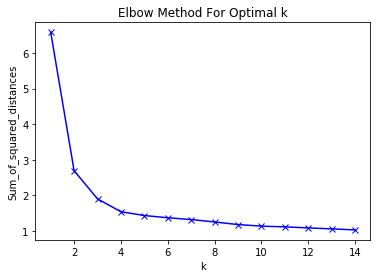

In [336]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The elbow seems to be at around 3-4, do let's define 4 clusters

In [337]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venues_cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:25] 

array([1, 1, 0, 1, 3, 1, 0, 1, 1, 1, 0, 1, 1, 3, 1, 3, 3, 3, 0, 1, 2, 2, 2,
       1, 1], dtype=int32)

Let's add the information to the venues dataframe

In [338]:
final_clusters=venues_grouped.copy()
final_clusters.insert(4, 'Cluster', kmeans.labels_)
final_clusters

,CityName,BoroughName,NeighborhoodName,Scaled Pop. Density,Cluster,ATM,Accessories Store,Adult Boutique,Adult Education Center,Advertising Agency,...,Well,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,DA,Darmstadt-Arheilgen,Alt-Arheilgen,0.107123,1,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.008850,0.000000,0.000000,0.000000,0.000000,0.000000
1,DA,Darmstadt-Arheilgen,Arheilgen-Ost,0.030451,1,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.008696,0.000000,0.000000,0.000000,0.000000,0.000000
2,DA,Darmstadt-Arheilgen,Arheilgen-Süd,0.237085,0,0.000000,0.000000,0.000000,0.014706,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,DA,Darmstadt-Arheilgen,Arheilgen-West,0.065253,1,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.008850,0.000000,0.000000,0.000000,0.000000,0.000000
4,DA,Darmstadt-Bessungen,Alt-Bessungen,0.470364,3,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.007937,0.000000,0.000000,0.000000,0.000000,0.000000
5,DA,Darmstadt-Bessungen,An der Ludwigshöhe,0.019032,1,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.013514,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,DA,Darmstadt-Bessungen,Paulusviertel,0.207722,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.008547,0.000000,0.000000,0.000000,0.000000,0.000000
7,DA,Darmstadt-Eberstadt,Alt-Eberstadt,0.108755,1,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,DA,Darmstadt-Eberstadt,Am Frankenstein,0.038608,1,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,DA,Darmstadt-Eberstadt,Am Lämmchesberg,0.058728,1,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Examine the clusters:

Cluster 0:

In [339]:
final_clusters.loc[final_clusters['Cluster'] == 0, final_clusters.columns[[0] + list(range(1,4))]]

,CityName,BoroughName,NeighborhoodName,Scaled Pop. Density
2,DA,Darmstadt-Arheilgen,Arheilgen-Süd,0.237085
6,DA,Darmstadt-Bessungen,Paulusviertel,0.207722
10,DA,Darmstadt-Eberstadt,Kirchtannensiedlung,0.249592
18,DA,Darmstadt-Mitte,Stadtzentrum,0.253399
31,DA,Darmstadt-West,Am Südbahnhof,0.342577
32,DA,Darmstadt-West,Heimstättensiedlung,0.180533
33,DA,Darmstadt-West,Verlegerviertel,0.234910
39,KA,Daxlanden,Daxlanden-Ost,0.326156
40,KA,Daxlanden,Neu-Daxlanden,0.235889
43,KA,Durlach,Aue,0.184557


Cluster 1:

In [340]:
final_clusters.loc[final_clusters['Cluster'] == 1, final_clusters.columns[[0] + list(range(1,4))]]

,CityName,BoroughName,NeighborhoodName,Scaled Pop. Density
0,DA,Darmstadt-Arheilgen,Alt-Arheilgen,0.107123
1,DA,Darmstadt-Arheilgen,Arheilgen-Ost,0.030451
3,DA,Darmstadt-Arheilgen,Arheilgen-West,0.065253
5,DA,Darmstadt-Bessungen,An der Ludwigshöhe,0.019032
7,DA,Darmstadt-Eberstadt,Alt-Eberstadt,0.108755
8,DA,Darmstadt-Eberstadt,Am Frankenstein,0.038608
9,DA,Darmstadt-Eberstadt,Am Lämmchesberg,0.058728
11,DA,Darmstadt-Eberstadt,Villenkolonie,0.027732
12,DA,Darmstadt-Kranichstein,Kranichstein-Nord,0.028820
14,DA,Darmstadt-Mitte,Hochschulviertel,0.071234


Cluster 2:

In [341]:
final_clusters.loc[final_clusters['Cluster'] == 2, final_clusters.columns[[0] + list(range(1,4))]]

,CityName,BoroughName,NeighborhoodName,Scaled Pop. Density
20,DA,Darmstadt-Nord,Johannesviertel,0.683524
21,DA,Darmstadt-Nord,Martinsviertel-Ost,1.000000
22,DA,Darmstadt-Nord,Martinsviertel-West,0.795541
59,KA,Innenstadt-Ost,Südwestl. Teil,0.802447
64,KA,Mühlburg,Alt-Mühlburg,0.731376
89,KA,Südstadt,Nördlicher Teil,0.883524
93,KA,Südweststadt,Mittlerer Teil,0.937520
100,KA,Weststadt,Südlicher Teil,0.824524


Cluster 3:

In [342]:
final_clusters.loc[final_clusters['Cluster'] == 3, final_clusters.columns[[0] + list(range(1,4))]]

,CityName,BoroughName,NeighborhoodName,Scaled Pop. Density
4,DA,Darmstadt-Bessungen,Alt-Bessungen,0.470364
13,DA,Darmstadt-Kranichstein,Kranichstein-Süd,0.381729
15,DA,Darmstadt-Mitte,Kapellplatzviertel,0.580750
16,DA,Darmstadt-Mitte,Rheintor/Grafenstraße,0.482327
17,DA,Darmstadt-Mitte,St. Ludwig mit Eichbergviertel,0.503535
28,DA,Darmstadt-Ost,Mathildenhöhe,0.373573
29,DA,Darmstadt-Ost,Woogsviertel,0.427950
36,KA,Beiertheim-Bulach,Beiertheim,0.407504
48,KA,Durlach,Lohn-Lissen,0.468733
65,KA,Mühlburg,Mühlburger Feld,0.415389


Try a hierarchical clustering process:

In [345]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [346]:
Z = linkage(venues_cluster, 'ward')

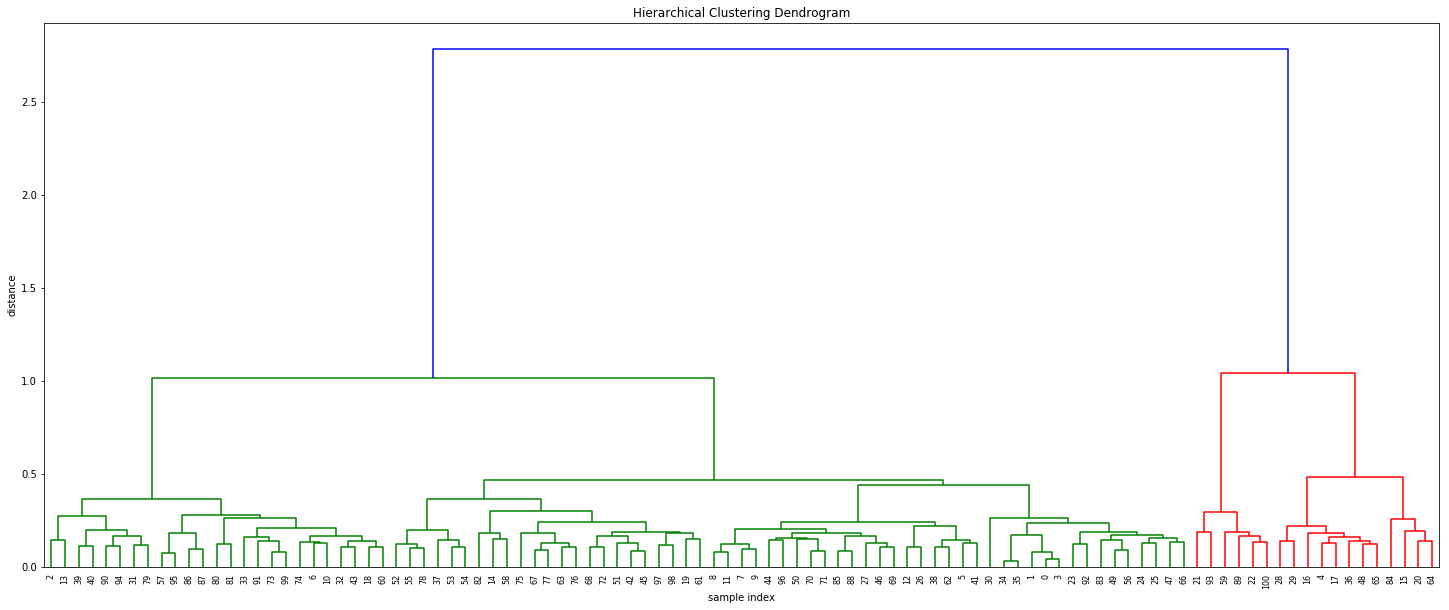

In [347]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    labels=venues_grouped.index
)
plt.show()

In [348]:
def getCityIndex(name):
    if(name=='KA'):
        return 0
    elif(name=='DA'):
        return 1
    else:
        print('City name %s not found!' %(name))
        exit()

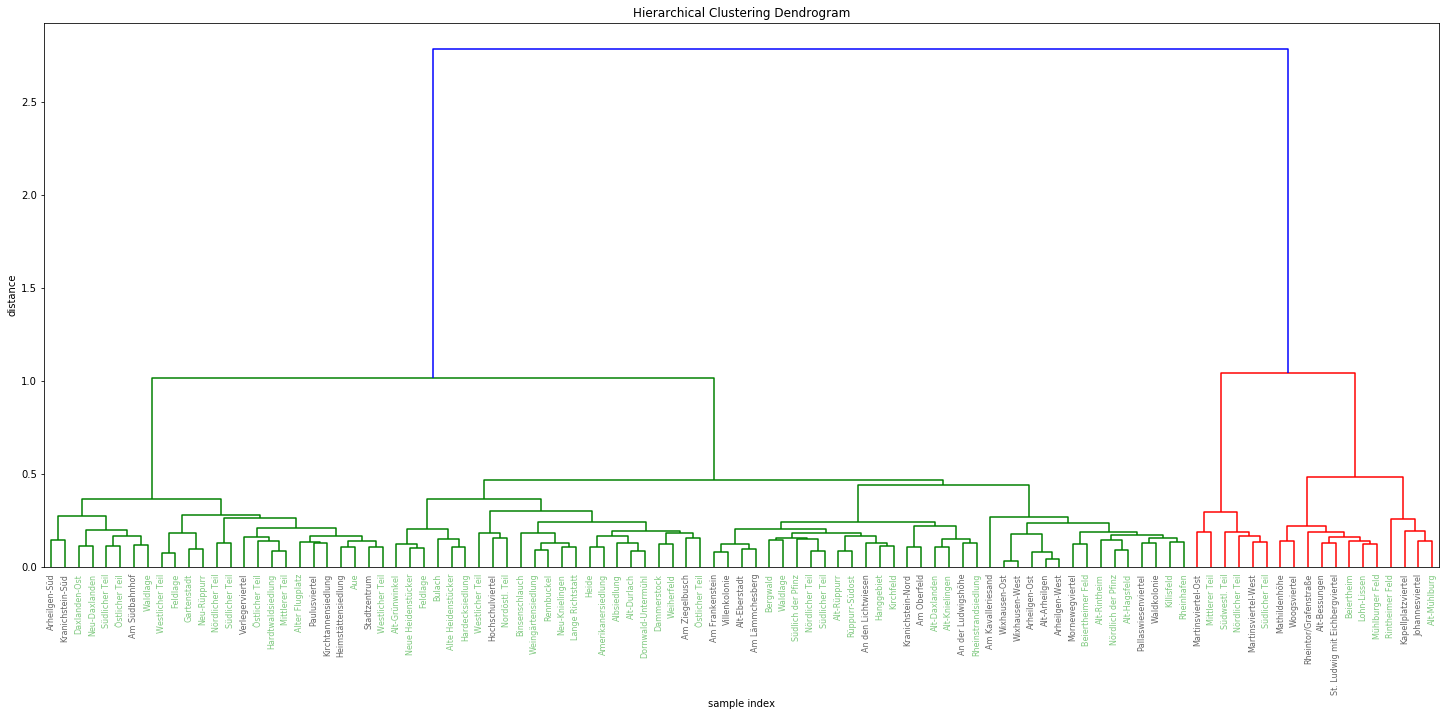

In [378]:
# calculate full dendrogram
df_temp=venues_grouped.copy()
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    labels=df_temp['NeighborhoodName'].tolist()
)

# Create a color palette with 2 colors (for KA and DA)
my_palette = plt.cm.get_cmap("Accent", 2)

ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for i in range(len(xlbls)):
    city_series=df_temp[df_temp['NeighborhoodName']==xlbls[i].get_text()].CityName # get the name of the city for the current neighborhood
    city_name=city_series.values[0]
    #print(city_series)
    val=getCityIndex(city_name)
    #print(city_name,val)
    xlbls[i].set_color(my_palette(val))
plt.show()

If we define the limit distance at around 0.8, we get 4 clusters, which coincides with the optimal k value found with k-Means 